In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

# Setting the aesthetics for plots
sns.set_theme(style="whitegrid")

# Initial exploration

In [2]:
# Load the dataset
cirrhosis = pd.read_csv('./../../data/cirrhosis.csv')

# Glimpse the dataset
display(cirrhosis.info())

# Sample 3 random rows from the dataset
sampled_rows = cirrhosis.sample(n=3)

# Display the sampled rows
sampled_rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

None

ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly  \
10    11    3762      D          Placebo  19619   F       N            Y   
298  299    1293      C  D-penicillamine  13913   F       N            N   
48    49     708      D          Placebo  22336   F       N            Y   

    Spiders Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
10        Y     N        1.4        259.0     4.16    46.0    1104.0   79.05   
298       N     N        2.4        342.0     3.76    90.0    1653.0  150.00   
48        N     N        0.8          NaN     3.82    58.0     678.0   97.65   

     Tryglicerides  Platelets  Prothrombin  Stage  
10            79.0      258.0         12.0    4.0  
298          127.0      213.0         10.8    3.0  
48             NaN      233.0         11.0    4.0

### Summary of the data

In [3]:
# Summary for numeric columns
numeric_summary = cirrhosis.describe()

# Get missing values count only for numeric columns
missing_values_numeric = cirrhosis[numeric_summary.columns].isnull().sum()

# Create a DataFrame for missing values to align with numeric_summary
missing_values_df = pd.DataFrame(missing_values_numeric, columns=['missing_values']).T

# Combine the summaries using concat
summary_df = pd.concat([numeric_summary, missing_values_df])

# Display the numeric summary
print('Summary of numeric columns')
display(summary_df.transpose())

# Summary for categorical columns
categorical_columns = cirrhosis.select_dtypes(include=['object']).columns
categorical_summary = pd.DataFrame(index=categorical_columns, columns=["mode", "freq", "missing_values"])
for column in categorical_columns:
    mode = cirrhosis[column].mode()[0]
    freq = cirrhosis[column].value_counts().iloc[0]
    missing = cirrhosis[column].isnull().sum()
    categorical_summary.loc[column] = [mode, freq, missing]

# Display the categoric summary
print('Summary of categoric columns')
display(categorical_summary)

Summary of numeric columns


count          mean          std      min         25%  \
ID             418.0    209.500000   120.810458     1.00    105.2500   
N_Days         418.0   1917.782297  1104.672992    41.00   1092.7500   
Age            418.0  18533.351675  3815.845055  9598.00  15644.5000   
Bilirubin      418.0      3.220813     4.407506     0.30      0.8000   
Cholesterol    284.0    369.510563   231.944545   120.00    249.5000   
Albumin        418.0      3.497440     0.424972     1.96      3.2425   
Copper         310.0     97.648387    85.613920     4.00     41.2500   
Alk_Phos       312.0   1982.655769  2140.388824   289.00    871.5000   
SGOT           312.0    122.556346    56.699525    26.35     80.6000   
Tryglicerides  282.0    124.702128    65.148639    33.00     84.2500   
Platelets      407.0    257.024570    98.325585    62.00    188.5000   
Prothrombin    416.0     10.731731     1.022000     9.00     10.0000   
Stage          412.0      3.024272     0.882042     1.00      2.0000   

                    50%       75%       max  missing_values  
ID               209.50    313.75    418.00             0.0  
N_Days          1730.00   2613.50   4795.00             0.0  
Age            18628.00  21272.50  28650.00             0.0  
Bilirubin          1.40      3.40     28.00             0.0  
Cholesterol      309.50    400.00   1775.00           134.0  
Albumin            3.53      3.77      4.64             0.0  
Copper            73.00    123.00    588.00           108.0  
Alk_Phos        1259.00   1980.00  13862.40           106.0  
SGOT             114.70    151.90    457.25           106.0  
Tryglicerides    108.00    151.00    598.00           136.0  
Platelets        251.00    318.00    721.00            11.0  
Prothrombin       10.60     11.10     18.00             2.0  
Stage              3.00      4.00      4.00             6.0

Summary of categoric columns


mode freq missing_values
Status                      C  232              0
Drug          D-penicillamine  158            106
Sex                         F  374              0
Ascites                     N  288            106
Hepatomegaly                Y  160            106
Spiders                     N  222            106
Edema                       N  354              0

Age can be transoformed to years, and stage can be categorical

In [4]:
# Convert Age from days to years and round to 1 decimal place
cirrhosis['Age'] = (cirrhosis['Age'] / 365).round(1)

# Convert Stage to a categorical type
cirrhosis['Stage'] = cirrhosis['Stage'].astype('category')

In [5]:
# Summary for numeric columns
numeric_summary = cirrhosis.describe()

# Get missing values count only for numeric columns
missing_values_numeric = cirrhosis[numeric_summary.columns].isnull().sum()

# Create a DataFrame for missing values to align with numeric_summary
missing_values_df = pd.DataFrame(missing_values_numeric, columns=['missing_values']).T

# Combine the summaries using concat
summary_df = pd.concat([numeric_summary, missing_values_df])

# Display the numeric summary
print('Summary of numeric columns')
display(summary_df.transpose())

# Summary for categorical columns
categorical_columns = cirrhosis.select_dtypes(include=['object', 'category']).columns
categorical_summary = pd.DataFrame(index=categorical_columns, columns=["mode", "freq", "missing_values"])
for column in categorical_columns:
    mode = cirrhosis[column].mode()[0]
    freq = cirrhosis[column].value_counts().iloc[0]
    missing = cirrhosis[column].isnull().sum()
    categorical_summary.loc[column] = [mode, freq, missing]

# Display the categoric summary
print('Summary of categoric columns')
display(categorical_summary)

Summary of numeric columns


count         mean          std     min        25%      50%  \
ID             418.0   209.500000   120.810458    1.00   105.2500   209.50   
N_Days         418.0  1917.782297  1104.672992   41.00  1092.7500  1730.00   
Age            418.0    50.767703    10.453390   26.30    42.8500    51.00   
Bilirubin      418.0     3.220813     4.407506    0.30     0.8000     1.40   
Cholesterol    284.0   369.510563   231.944545  120.00   249.5000   309.50   
Albumin        418.0     3.497440     0.424972    1.96     3.2425     3.53   
Copper         310.0    97.648387    85.613920    4.00    41.2500    73.00   
Alk_Phos       312.0  1982.655769  2140.388824  289.00   871.5000  1259.00   
SGOT           312.0   122.556346    56.699525   26.35    80.6000   114.70   
Tryglicerides  282.0   124.702128    65.148639   33.00    84.2500   108.00   
Platelets      407.0   257.024570    98.325585   62.00   188.5000   251.00   
Prothrombin    416.0    10.731731     1.022000    9.00    10.0000    10.60   

                    75%       max  missing_values  
ID              313.750    418.00             0.0  
N_Days         2613.500   4795.00             0.0  
Age              58.275     78.50             0.0  
Bilirubin         3.400     28.00             0.0  
Cholesterol     400.000   1775.00           134.0  
Albumin           3.770      4.64             0.0  
Copper          123.000    588.00           108.0  
Alk_Phos       1980.000  13862.40           106.0  
SGOT            151.900    457.25           106.0  
Tryglicerides   151.000    598.00           136.0  
Platelets       318.000    721.00            11.0  
Prothrombin      11.100     18.00             2.0

Summary of categoric columns


mode freq missing_values
Status                      C  232              0
Drug          D-penicillamine  158            106
Sex                         F  374              0
Ascites                     N  288            106
Hepatomegaly                Y  160            106
Spiders                     N  222            106
Edema                       N  354              0
Stage                     3.0  155              6

### Handling missing data

In [6]:
# Create a DataFrame to store the missing data pattern
missing_pattern = pd.DataFrame(0, index=cirrhosis.index, columns=cirrhosis.columns)

# Update the DataFrame with missing data pattern
for index, row in cirrhosis.iterrows():
    missing_columns = row[row.isnull()].index
    missing_pattern.loc[index, missing_columns] = 1

# Now, missing_pattern contains a 1 for missing entries and 0 for non-missing
display(missing_pattern)

# Summarize the pattern by column
missing_pattern_summary = missing_pattern.sum()

# Display the missing pattern summary
display(missing_pattern_summary)

ID  N_Days  Status  Drug  Age  Sex  Ascites  Hepatomegaly  Spiders  \
0     0       0       0     0    0    0        0             0        0   
1     0       0       0     0    0    0        0             0        0   
2     0       0       0     0    0    0        0             0        0   
3     0       0       0     0    0    0        0             0        0   
4     0       0       0     0    0    0        0             0        0   
..   ..     ...     ...   ...  ...  ...      ...           ...      ...   
413   0       0       0     1    0    0        1             1        1   
414   0       0       0     1    0    0        1             1        1   
415   0       0       0     1    0    0        1             1        1   
416   0       0       0     1    0    0        1             1        1   
417   0       0       0     1    0    0        1             1        1   

     Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  SGOT  \
0        0          0            0        0       0         0     0   
1        0          0            0        0       0         0     0   
2        0          0            0        0       0         0     0   
3        0          0            0        0       0         0     0   
4        0          0            0        0       0         0     0   
..     ...        ...          ...      ...     ...       ...   ...   
413      0          0            1        0       1         1     1   
414      0          0            1        0       1         1     1   
415      0          0            1        0       1         1     1   
416      0          0            1        0       1         1     1   
417      0          0            1        0       1         1     1   

     Tryglicerides  Platelets  Prothrombin  Stage  
0                0          0            0      0  
1                0          0            0      0  
2                0          0            0      0  
3                0          0            0      0  
4                0          0            0      0  
..             ...        ...          ...    ...  
413              1          0            0      0  
414              1          0            0      0  
415              1          0            0      0  
416              1          0            0      0  
417              1          0            0      0  

[418 rows x 20 columns]

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

<Axes: >

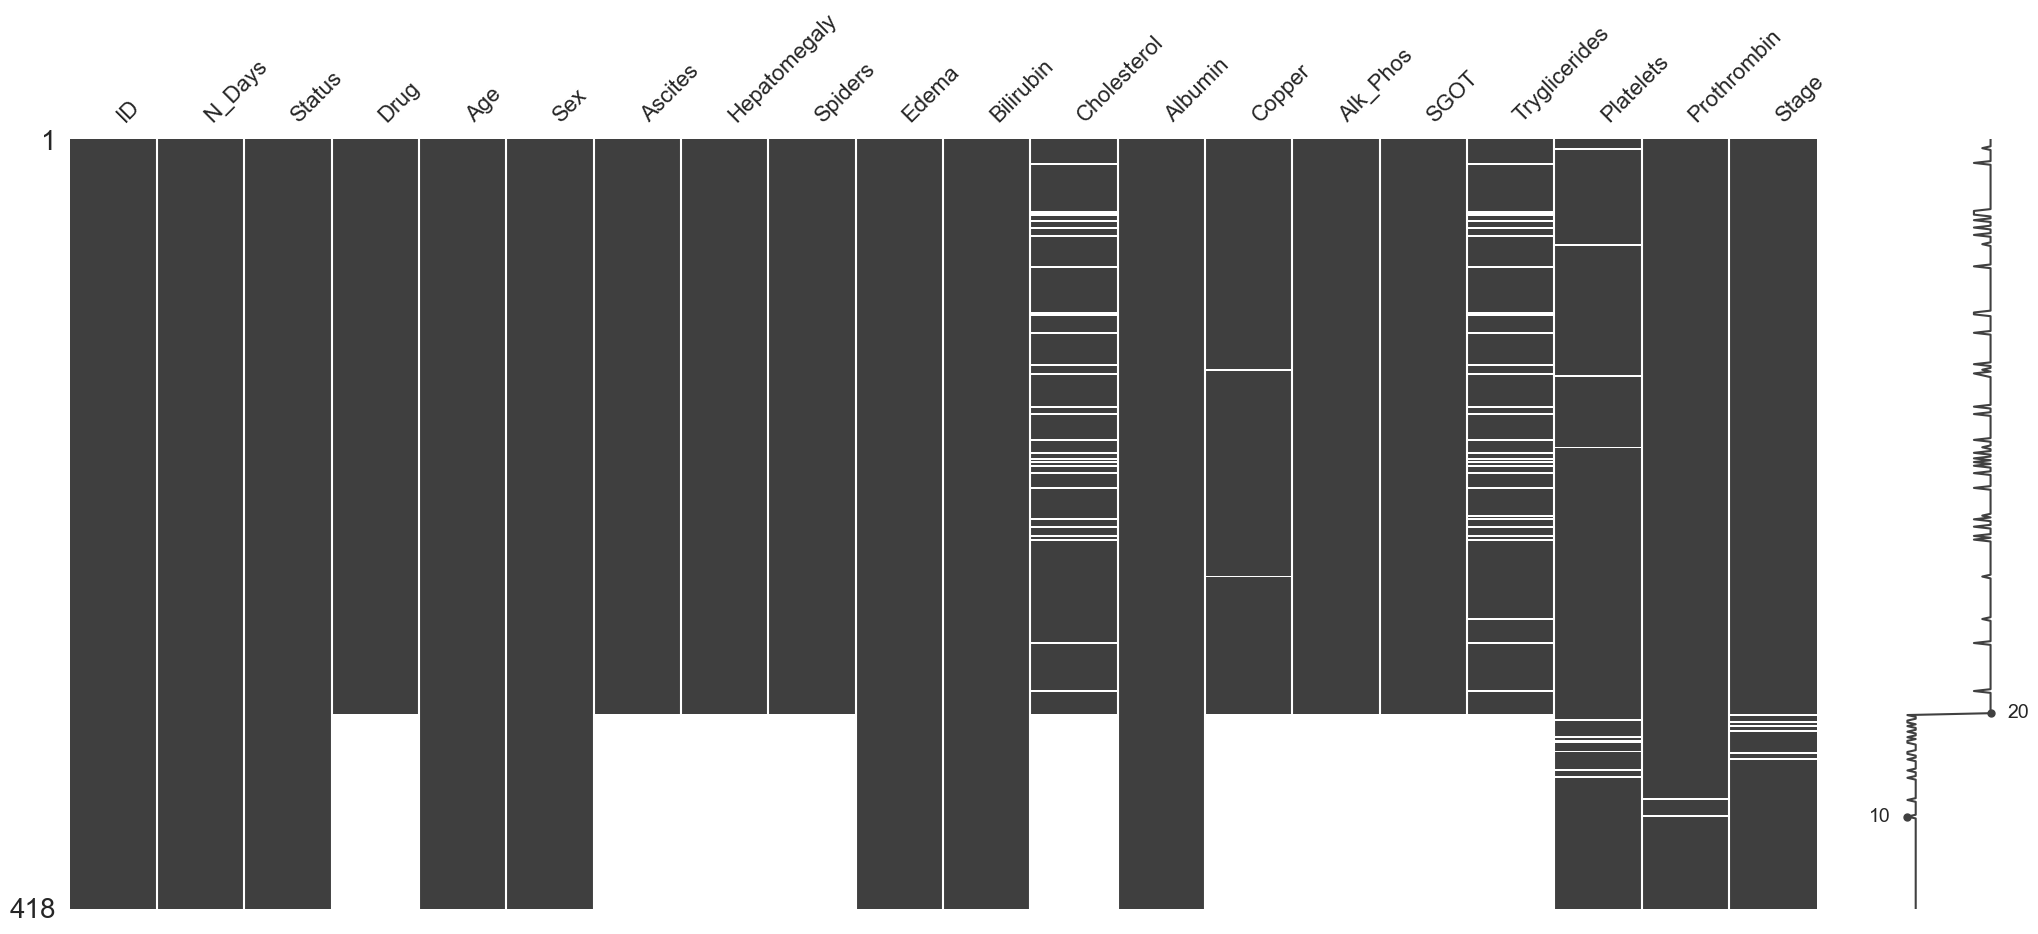

In [7]:
import missingno as msno

# Visualize the missing data pattern
msno.matrix(cirrhosis)

The last rows where the drug is missing, could potentially be the rows of the 106 patients who did not participate in the trial. For now, I'll remove them just to follow the tutorial.

Number of rows and columns after removing NAs in Drug column: (312, 20)


<Axes: >

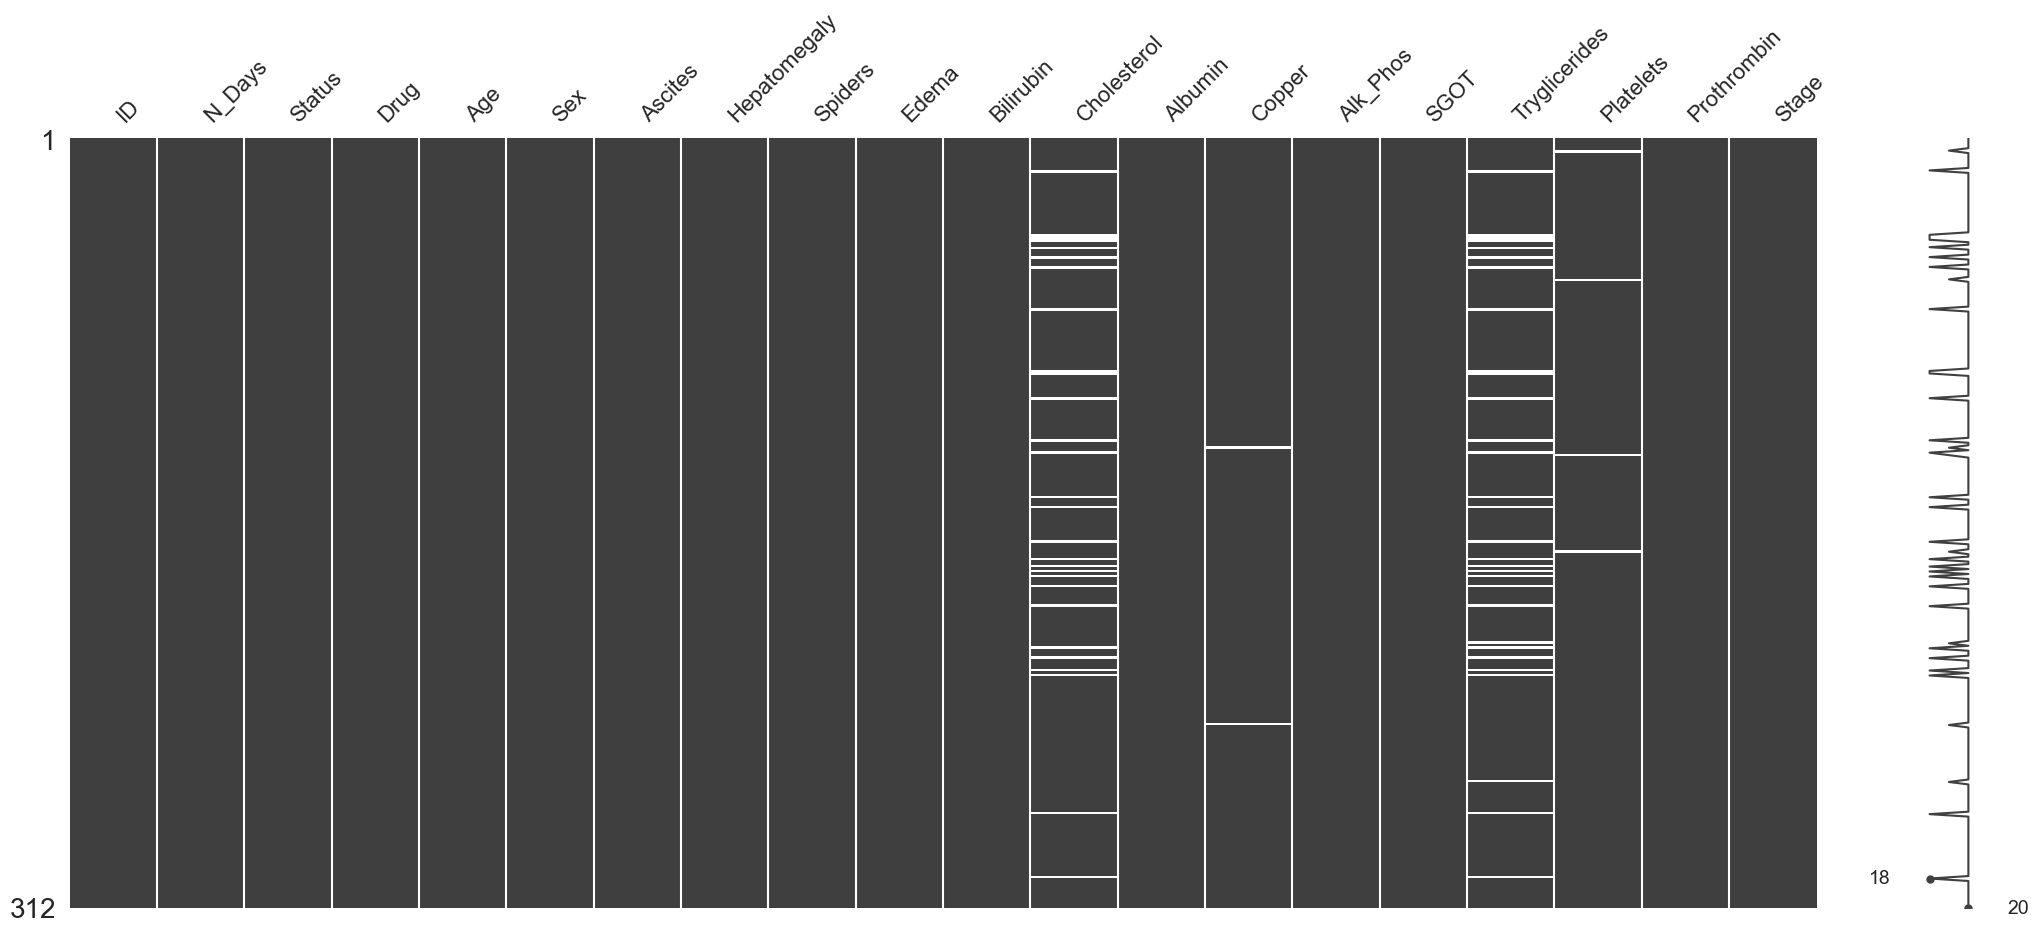

In [8]:
# Filter out rows where 'Drug' column is NA
cirrhosis_cleaned = cirrhosis.dropna(subset=['Drug'])

# Get the dimensions of the DataFrame
dimensions = cirrhosis_cleaned.shape

# Display the dimensions
print('Number of rows and columns after removing NAs in Drug column:', dimensions)

# Visualize the missing data pattern
msno.matrix(cirrhosis_cleaned)

We can see that there are still some missing values in some columns. Inputting data using Iterative imputer and Random Forest Regressor

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

# Encode categorical columns
encoder = OrdinalEncoder()
cirrhosis_encoded = cirrhosis.copy()
categorical_cols = cirrhosis_encoded.select_dtypes(include=['object', 'category']).columns
cirrhosis_encoded[categorical_cols] = encoder.fit_transform(cirrhosis_encoded[categorical_cols].astype(str))

# Impute the whole dataset, assuming all data can be cast to float
# The imputer is fit on the entire dataset here for simplicity; you could fit only on the numerical data if preferred
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=20, random_state=0)
cirrhosis_imputed = imputer.fit_transform(cirrhosis_encoded)

# Decode the categorical columns back to original values
cirrhosis_imputed_df = pd.DataFrame(cirrhosis_imputed, columns=cirrhosis_encoded.columns)
cirrhosis_imputed_df[categorical_cols] = encoder.inverse_transform(cirrhosis_imputed_df[categorical_cols])

# Check the first few rows of the imputed DataFrame
display(cirrhosis_imputed_df)

/Users/jhuertas6/opt/anaconda3/envs/CDAprojenv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


ID  N_Days Status             Drug   Age Sex Ascites Hepatomegaly  \
0      1.0   400.0      D  D-penicillamine  58.8   F       Y            Y   
1      2.0  4500.0      C  D-penicillamine  56.5   F       N            Y   
2      3.0  1012.0      D  D-penicillamine  70.1   M       N            N   
3      4.0  1925.0      D  D-penicillamine  54.8   F       N            Y   
4      5.0  1504.0     CL          Placebo  38.1   F       N            Y   
..     ...     ...    ...              ...   ...  ..     ...          ...   
413  414.0   681.0      D              nan  67.0   F     nan          nan   
414  415.0  1103.0      C              nan  39.0   F     nan          nan   
415  416.0  1055.0      C              nan  57.0   F     nan          nan   
416  417.0   691.0      C              nan  58.0   F     nan          nan   
417  418.0   976.0      C              nan  53.0   F     nan          nan   

    Spiders Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
0         Y     Y       14.5       261.00     2.60  156.00   1718.00   
1         Y     N        1.1       302.00     4.14   54.00   7394.80   
2         N     S        1.4       176.00     3.48  210.00    516.00   
3         Y     S        1.8       244.00     2.54   64.00   6121.80   
4         Y     N        3.4       279.00     3.53  143.00    671.00   
..      ...   ...        ...          ...      ...     ...       ...   
413     nan     N        1.2       324.38     2.96  116.87   1132.79   
414     nan     N        0.9       360.22     3.83   80.49   1299.42   
415     nan     N        1.6       306.16     3.42   70.78   1031.08   
416     nan     N        0.8       342.00     3.75   97.13   1088.79   
417     nan     N        0.7       294.97     3.29   53.25   1213.05   

         SGOT  Tryglicerides  Platelets  Prothrombin Stage  
0    137.9500         172.00      190.0         12.2   4.0  
1    113.5200          88.00      221.0         10.6   3.0  
2     96.1000          55.00      151.0         12.0   4.0  
3     60.6300          92.00      183.0         10.3   4.0  
4    113.1500          72.00      136.0         10.9   3.0  
..        ...            ...        ...          ...   ...  
413  100.1179         122.40      174.0         10.9   3.0  
414  131.2561         101.57      180.0         11.2   4.0  
415  104.4939         117.59      143.0          9.9   3.0  
416   94.4415         116.27      269.0         10.4   3.0  
417  111.1610          96.38      350.0         10.6   4.0  

[418 rows x 20 columns]

<Axes: >

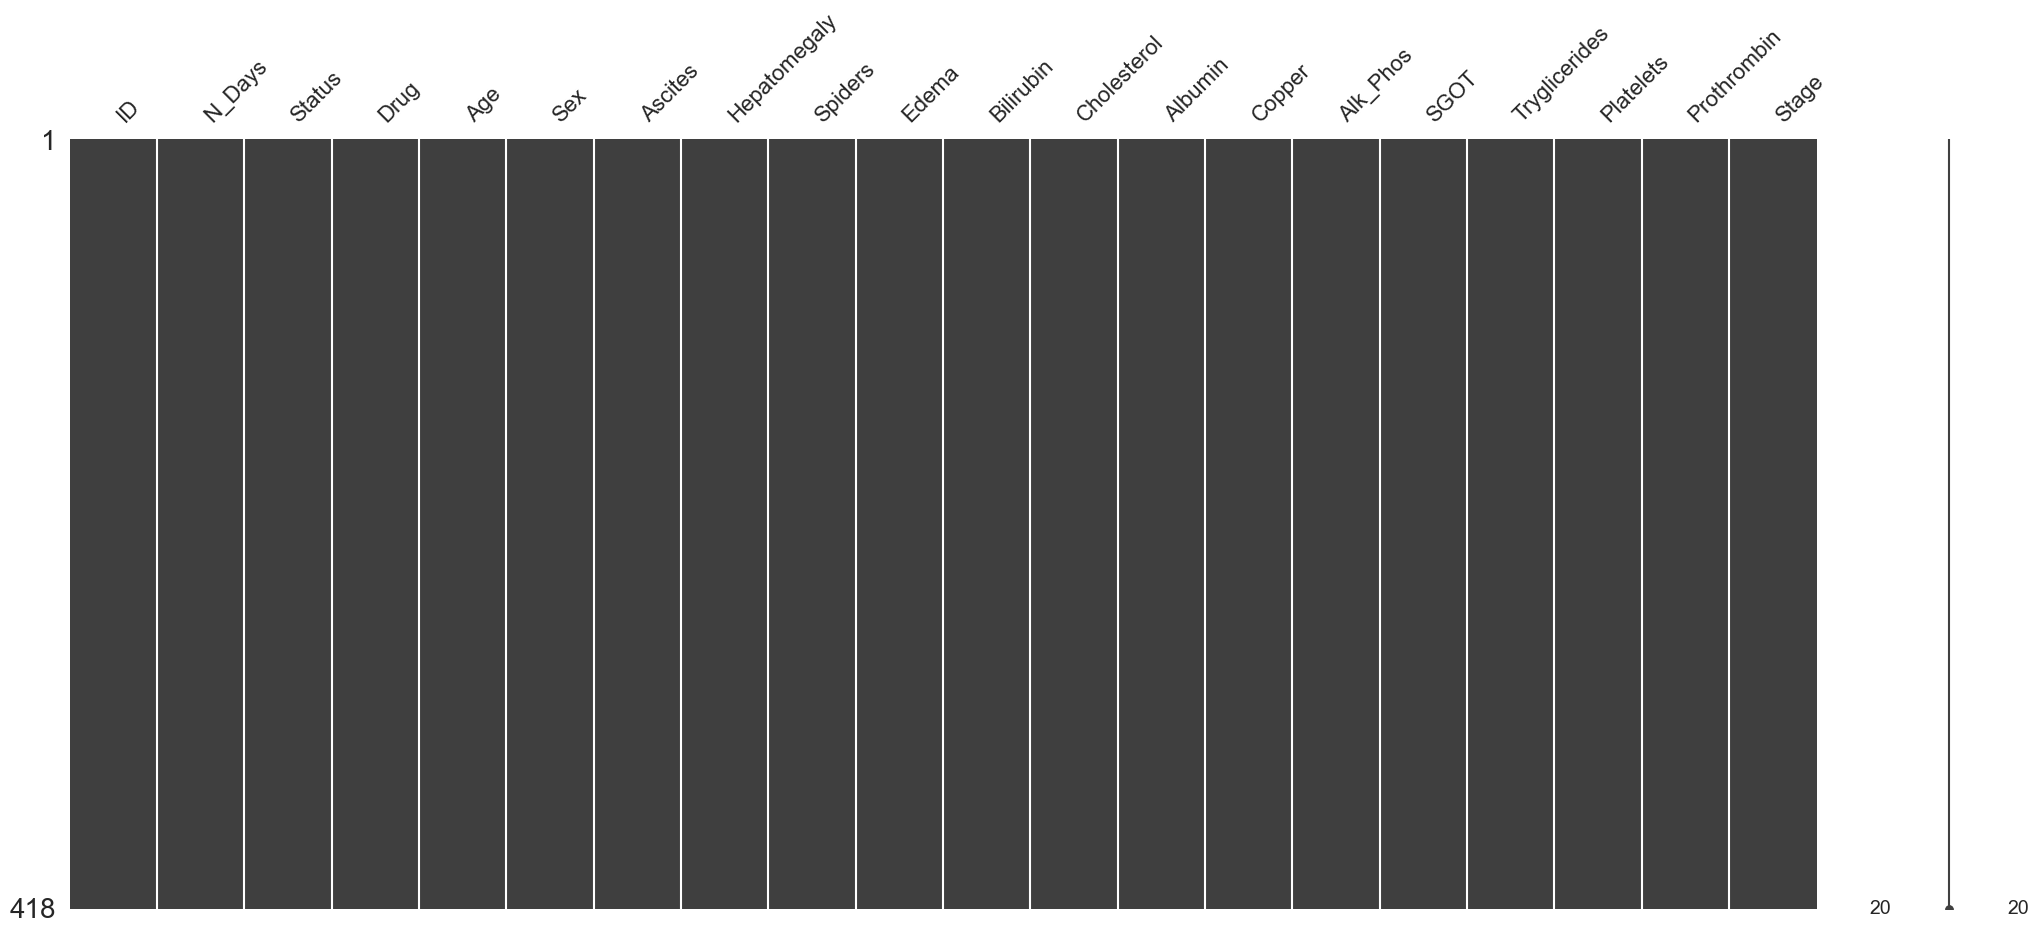

In [10]:
# Visualize the missing data pattern
msno.matrix(cirrhosis_imputed_df)

### Data manipulation and visualization

In [15]:
len(cirrhosis_imputed_df.columns)

20

In [32]:
# Drop ID and reorder columns
columns = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Drug', 'Sex', 'N_Days']
cirrhosis_filtered = cirrhosis_imputed_df[columns]
display(cirrhosis_filtered)

Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos      SGOT  \
0    58.8       14.5       261.00     2.60  156.00   1718.00  137.9500   
1    56.5        1.1       302.00     4.14   54.00   7394.80  113.5200   
2    70.1        1.4       176.00     3.48  210.00    516.00   96.1000   
3    54.8        1.8       244.00     2.54   64.00   6121.80   60.6300   
4    38.1        3.4       279.00     3.53  143.00    671.00  113.1500   
..    ...        ...          ...      ...     ...       ...       ...   
413  67.0        1.2       324.38     2.96  116.87   1132.79  100.1179   
414  39.0        0.9       360.22     3.83   80.49   1299.42  131.2561   
415  57.0        1.6       306.16     3.42   70.78   1031.08  104.4939   
416  58.0        0.8       342.00     3.75   97.13   1088.79   94.4415   
417  53.0        0.7       294.97     3.29   53.25   1213.05  111.1610   

     Tryglicerides  Platelets  Prothrombin Stage             Drug Sex  N_Days  
0           172.00      190.0         12.2   4.0  D-penicillamine   F   400.0  
1            88.00      221.0         10.6   3.0  D-penicillamine   F  4500.0  
2            55.00      151.0         12.0   4.0  D-penicillamine   M  1012.0  
3            92.00      183.0         10.3   4.0  D-penicillamine   F  1925.0  
4            72.00      136.0         10.9   3.0          Placebo   F  1504.0  
..             ...        ...          ...   ...              ...  ..     ...  
413         122.40      174.0         10.9   3.0              nan   F   681.0  
414         101.57      180.0         11.2   4.0              nan   F  1103.0  
415         117.59      143.0          9.9   3.0              nan   F  1055.0  
416         116.27      269.0         10.4   3.0              nan   F   691.0  
417          96.38      350.0         10.6   4.0              nan   F   976.0  

[418 rows x 14 columns]

/Users/jhuertas6/opt/anaconda3/envs/CDAprojenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jhuertas6/opt/anaconda3/envs/CDAprojenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jhuertas6/opt/anaconda3/envs/CDAprojenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jh

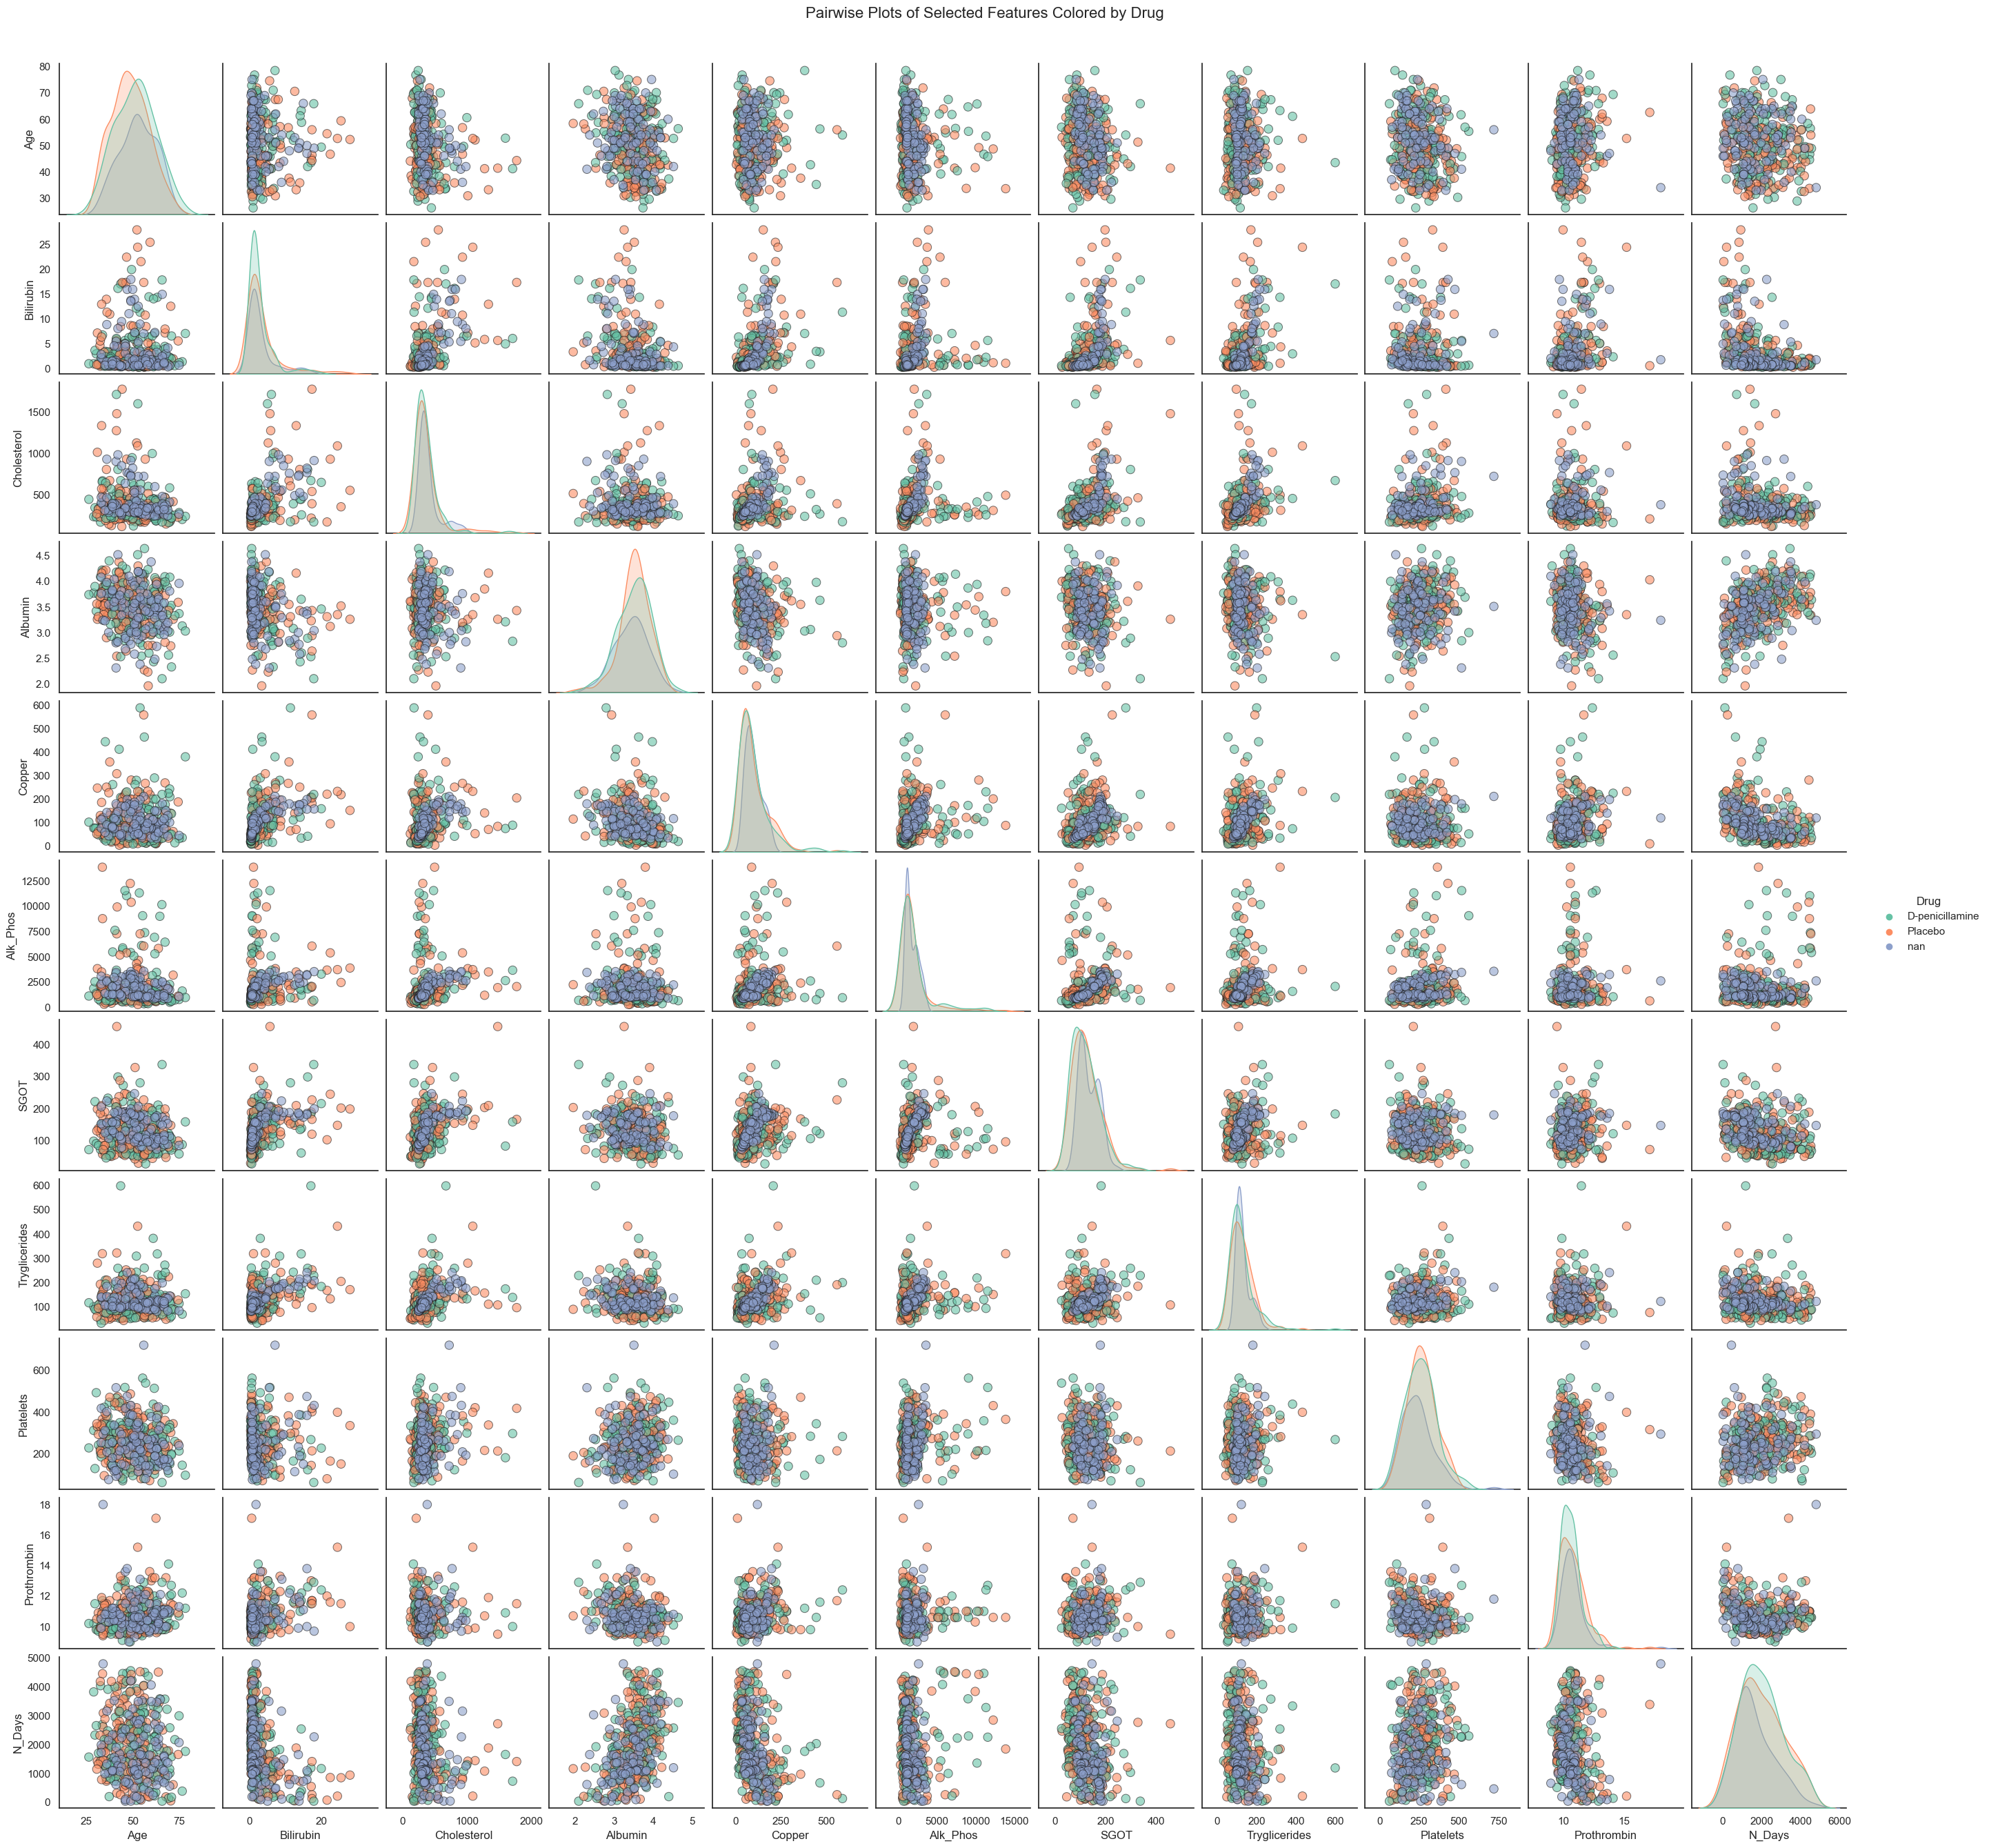

In [33]:
# Set the aesthetic style of the plots
sns.set(style="white")

# Create a pairplot with color by 'Drug', using seaborn
g = sns.pairplot(cirrhosis_filtered, hue='Drug', palette='Set2', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height=2.5)

# Adjust the top margin to fit the legend on the plot
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Pairwise Plots of Selected Features Colored by Drug', fontsize=16)

# Show the plot
plt.show()

/Users/jhuertas6/opt/anaconda3/envs/CDAprojenv/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


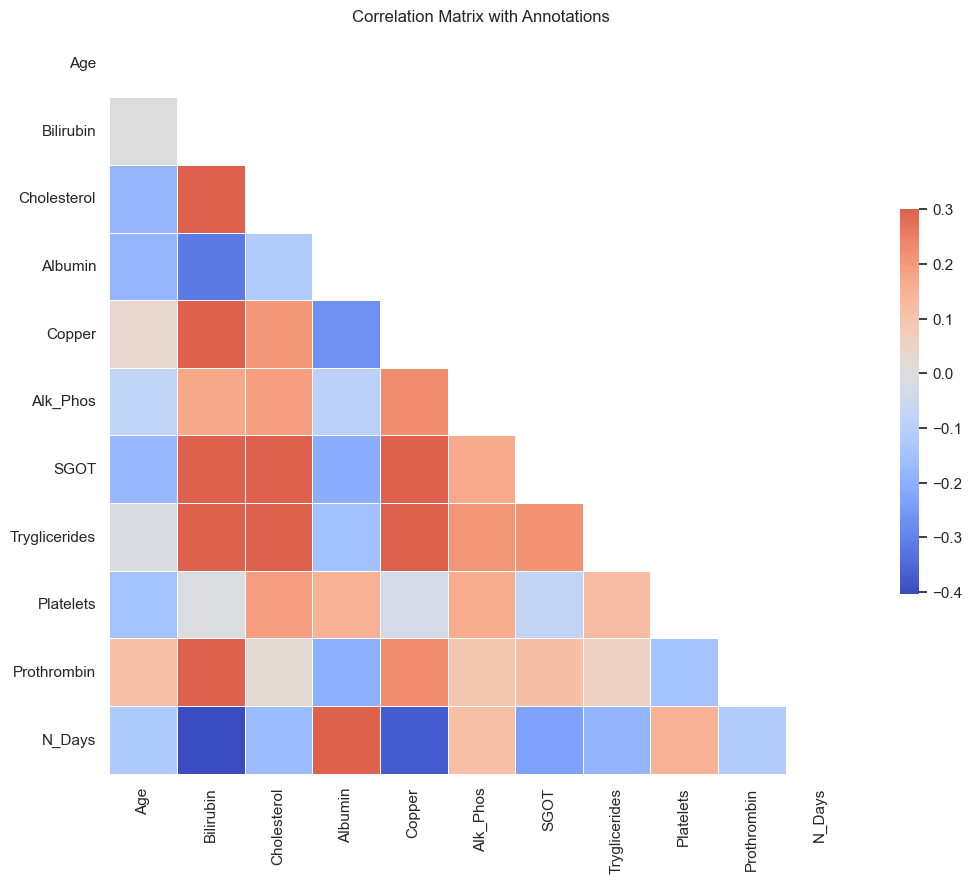

In [34]:
# Calculate the correlation matrix for numeric columns only
correlation_matrix = cirrhosis_filtered.select_dtypes(include=[np.number]).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Add title
plt.title('Correlation Matrix with Annotations')

# Show plot
plt.show()

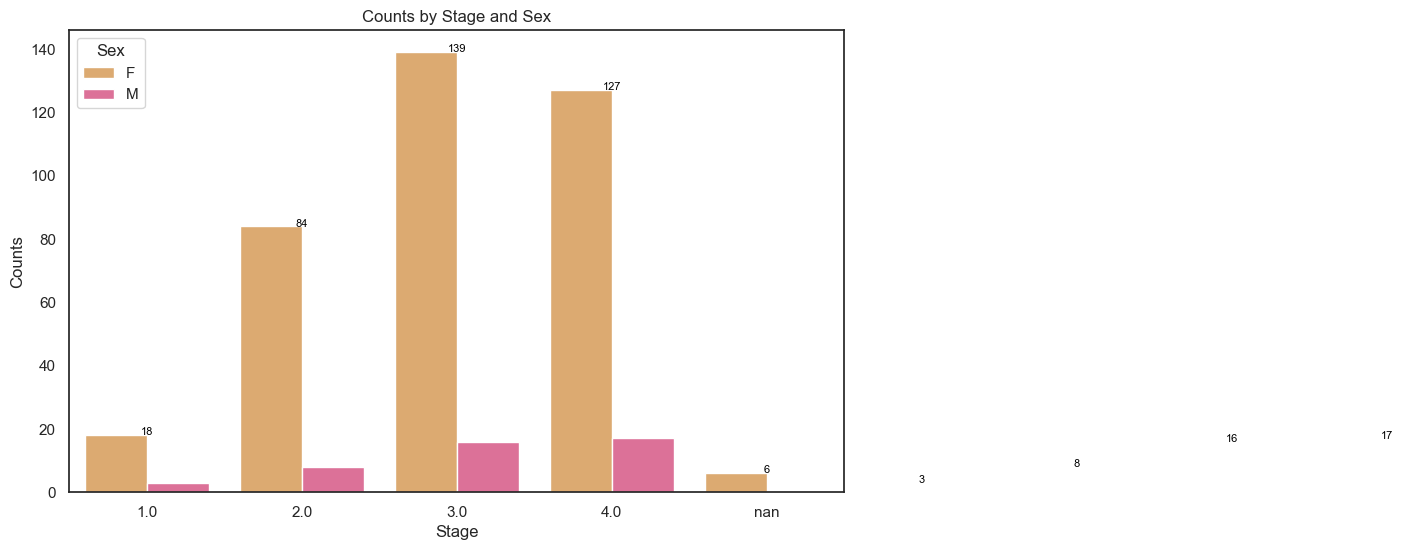

In [39]:
# Group the data by 'Sex' and 'Stage' and count the occurrences
grouped_df = cirrhosis_imputed_df.groupby(['Sex', 'Stage']).size().reset_index(name='counts')

# Start the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_df, x='Stage', y='counts', hue='Sex', palette=["#EEAB5F", "#EE5F93"], dodge=True)

# Add counts above the bars
for index, row in grouped_df.iterrows():
    ax.text(row.name, row.counts, round(row.counts,2), color='black', ha="center", size=8)

# Set plot title and labels
plt.title('Counts by Stage and Sex')
plt.xlabel('Stage')
plt.ylabel('Counts')

# Show the plot
plt.show()

In [38]:
cirrhosis_imputed_df.query('Stage.isna()')

Empty DataFrame
Columns: [ID, N_Days, Status, Drug, Age, Sex, Ascites, Hepatomegaly, Spiders, Edema, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin, Stage]
Index: []